In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [ ]:

# ===========================
# 1. MLP 모델 정의
# ===========================
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=200, num_classes=10):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )
    def forward(self, x):
        return self.layers(x)

In [ ]:
# ===========================
# 2. 기본 설정
# ===========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# MNIST 로드
mnist = load_dataset("mnist")

# 정규화 통계 추정
sample_data = torch.stack([
    transforms.ToTensor()(mnist['train'][i]['image'])
    for i in range(1000)
])
mean, std = sample_data.mean().item(), sample_data.std().item()

# 데이터 변환 정의
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# 변환 적용 함수
def transform_dataset(dataset):
    def transform_fn(batch):
        images = [transform(img).view(-1) for img in batch["image"]]
        return {"image": torch.stack(images), "label": torch.tensor(batch["label"])}
    return dataset.with_transform(transform_fn)

train_dataset = transform_dataset(mnist["train"])
test_dataset = transform_dataset(mnist["test"])

# DataLoader
def get_loaders(batch_size=128):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    return train_loader, test_loader


Using device: cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

mnist/train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

mnist/test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
# ===========================
# 3. 학습 함수
# ===========================
def train_and_evaluate(hidden_size, lr=1e-3, epochs=3, batch_size=128):
    # 모델, 손실함수, 옵티마이저
    model = MLP(hidden_size=hidden_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_loader, test_loader = get_loaders(batch_size)

    # 학습 루프
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            imgs, labels = batch["image"].to(device), batch["label"].to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # 테스트 정확도 평가
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            imgs, labels = batch["image"].to(device), batch["label"].to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    test_acc = 100 * correct / total
    return test_acc


In [ ]:
# ===========================
# 4. 자동 반복 실험
# ===========================
hidden_sizes = [50, 100, 200, 400]  # 은닉층 크기 후보
n_runs = 10  # 각 설정을 몇 번 반복할지

results = defaultdict(list)

print("\n=== 실험 시작 ===")
for h in hidden_sizes:
    print(f"\n[은닉층 {h}]")
    for run in range(n_runs):
        acc = train_and_evaluate(hidden_size=h)
        results[h].append(acc)
        print(f"  Run {run+1}/{n_runs}: Test Acc = {acc:.2f}%")


=== 실험 시작 ===

[은닉층 50]
  Run 1/10: Test Acc = 96.34%
  Run 2/10: Test Acc = 96.12%
  Run 3/10: Test Acc = 96.04%
  Run 4/10: Test Acc = 96.30%
  Run 5/10: Test Acc = 96.27%
  Run 6/10: Test Acc = 96.22%
  Run 7/10: Test Acc = 96.07%
  Run 8/10: Test Acc = 95.98%
  Run 9/10: Test Acc = 96.40%
  Run 10/10: Test Acc = 96.12%

[은닉층 100]
  Run 1/10: Test Acc = 97.00%
  Run 2/10: Test Acc = 96.93%
  Run 3/10: Test Acc = 96.90%
  Run 4/10: Test Acc = 96.82%
  Run 5/10: Test Acc = 97.21%
  Run 6/10: Test Acc = 96.89%
  Run 7/10: Test Acc = 97.12%
  Run 8/10: Test Acc = 96.98%
  Run 9/10: Test Acc = 96.91%
  Run 10/10: Test Acc = 96.96%

[은닉층 200]
  Run 1/10: Test Acc = 97.05%
  Run 2/10: Test Acc = 97.50%
  Run 3/10: Test Acc = 97.56%
  Run 4/10: Test Acc = 97.19%
  Run 5/10: Test Acc = 97.38%
  Run 6/10: Test Acc = 97.42%
  Run 7/10: Test Acc = 97.50%
  Run 8/10: Test Acc = 97.35%
  Run 9/10: Test Acc = 97.45%
  Run 10/10: Test Acc = 97.56%

[은닉층 400]
  Run 1/10: Test Acc = 97.77%
  Run 2/1

In [ ]:
# ===========================
# 5. 결과 요약
# ===========================
print("\n=== 실험 결과 요약 ===")
means, stds = [], []
for h in hidden_sizes:
    mean_acc = np.mean(results[h])
    std_acc = np.std(results[h])
    means.append(mean_acc)
    stds.append(std_acc)
    print(f"은닉층 {h}: 평균 정확도 = {mean_acc:.2f}%, 표준편차 = {std_acc:.2f}")



=== 실험 결과 요약 ===
은닉층 50: 평균 정확도 = 96.19%, 표준편차 = 0.13
은닉층 100: 평균 정확도 = 96.97%, 표준편차 = 0.11
은닉층 200: 평균 정확도 = 97.40%, 표준편차 = 0.16
은닉층 400: 평균 정확도 = 97.62%, 표준편차 = 0.15


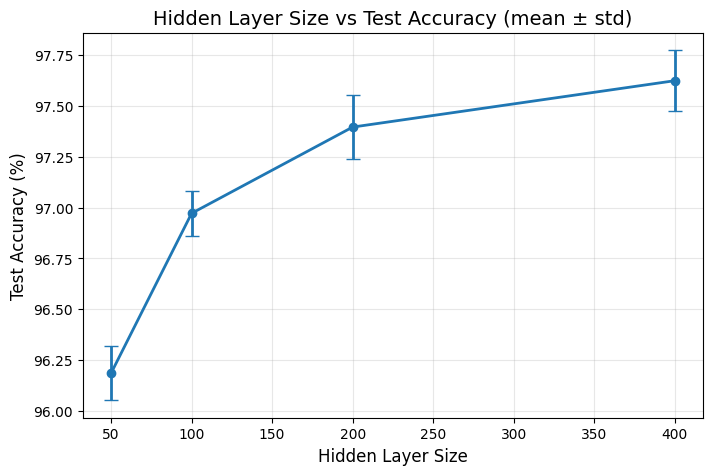

In [ ]:
# ===========================
# 6. 경향성 시각화
# ===========================
plt.figure(figsize=(8,5))
plt.errorbar(hidden_sizes, means, yerr=stds, fmt='-o', capsize=5, lw=2)
plt.title("Hidden Layer Size vs Test Accuracy (mean ± std)", fontsize=14)
plt.xlabel("Hidden Layer Size", fontsize=12)
plt.ylabel("Test Accuracy (%)", fontsize=12)
plt.grid(alpha=0.3)
plt.show()